<a href="https://colab.research.google.com/github/Sunkyoung/PyTorch-Study/blob/main/PyTorch_Study_04_Autoencoder(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

## Practice Notebook Problem Solution
### **TODO : Fill the answer below Q**

## 1. Settings

### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 50

## 2. Data

### 1) Download Data

In [3]:
from torchvision import datasets

mnist_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Q : Print data shape
# Hint) data shape (1, 28, 28)
mnist_train[0][0].size()

torch.Size([1, 28, 28])

In [5]:
# first example label
mnist_train[0][1]

5

### 2) Set DataLoader

In [6]:
# Q : Define three data loader (train, valid, test) using torch.utils.data.DataLoader
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [7]:
len(dataloaders["train"])

196

## 3. Model & Optimizer

### 1) Model

In [8]:
# build your own autoencoder
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        # Q : Define encoder block that two linear layers and ReLU activation
        #     first linear layer : input dimension 784, output dimension 100
        #     second linear layer : input dimension 100, output dimension 30
        # Hint) activation function use after linear layer
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=30),
            nn.ReLU()
        )

        # Q : Define decoder block that two linear layers and ReLU activation
        #     linear layer in/out dimension is reversed order of linear layers above the encoder block
        # Hint) activation function use after linear layer
        self.decoder = nn.Sequential(
            nn.Linear(in_features=30, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=784),
            nn.ReLU()
        )

                
    def forward(self, x):
        # Q : Define batch size
        # Hint) x.shape -> (batch_size, data shape) 
        #       data shape is from fourth block
        batch_size = x.size(0)

        # Q : Reshape x to put encoder block
        # Hint) first linear layer input dimension is 784 (28,28)
        #       the size -1 is inferred from other dimensions
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)

        # Q : Reshape decoder output to original x shape. Fill the ???
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)
        return out, encoded


### 2) Loss func & Optimizer

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# Q : Define model to Autoencoder and load to GPU
model = Autoencoder().to(device)

In [11]:
# Q : Define loss function and optimizer
#     We use Mean Squared Loss (MSE loss), and Adam optimizer with defined learning_rate
# Hint)
# https://pytorch.org/docs/stable/nn.html#loss-functions
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [12]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Q : Set model to training mode
                model.train()
            else:
                # Q : Set model to evaluate mode
                model.eval()

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Load input data to GPU
                inputs = inputs.cuda()

                # Q : Set parameter gradients zero
                # Hint) Related to 'optimizer'
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Q : input forward to model and fill ??? in loss function
                    outputs, encoded = model(inputs)
                    loss = loss_fn(outputs, inputs) # calculate a loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Q : perform back-propagation and perform gradient descent
                        # Hint ) Backprop is related to 'loss' and Gradient descent is related to 'optimizer'
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # Q : Load best model weights. Fill ???
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [13]:
# Train model
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_fn, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.0765
val Loss: 0.0560
Epoch 1/49
----------
train Loss: 0.0449
val Loss: 0.0388
Epoch 2/49
----------
train Loss: 0.0361
val Loss: 0.0339
Epoch 3/49
----------
train Loss: 0.0322
val Loss: 0.0311
Epoch 4/49
----------
train Loss: 0.0300
val Loss: 0.0293
Epoch 5/49
----------
train Loss: 0.0286
val Loss: 0.0281
Epoch 6/49
----------
train Loss: 0.0276
val Loss: 0.0273
Epoch 7/49
----------
train Loss: 0.0269
val Loss: 0.0267
Epoch 8/49
----------
train Loss: 0.0264
val Loss: 0.0263
Epoch 9/49
----------
train Loss: 0.0260
val Loss: 0.0259
Epoch 10/49
----------
train Loss: 0.0256
val Loss: 0.0255
Epoch 11/49
----------
train Loss: 0.0253
val Loss: 0.0252
Epoch 12/49
----------
train Loss: 0.0250
val Loss: 0.0250
Epoch 13/49
----------
train Loss: 0.0247
val Loss: 0.0247
Epoch 14/49
----------
train Loss: 0.0245
val Loss: 0.0245
Epoch 15/49
----------
train Loss: 0.0243
val Loss: 0.0243
Epoch 16/49
----------
train Loss: 0.0241
val Loss: 0.0242
Epoch 1

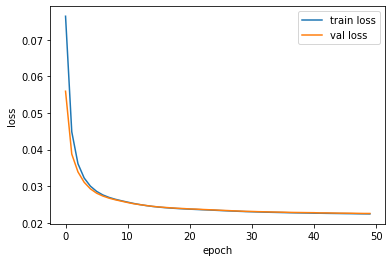

In [14]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

## 5. Check with Test Image

In [15]:
# Q : Implement the trained best model test code (8 lines)
#     1. NO gradient calculation
#     2. Total loss is to 0.0
#     3. Iterate the test dataloader (from defined dataloaders 'dictionary')
#     4. Load inputs to GPU
#     5. Forward inputs to model (best_model from above training)
#     6. Calculate loss
#     7. Add to the total loss (2.)
#     8. Calculate test loss
with torch.no_grad():
  total_loss = 0.0
  for inputs, labels in dataloaders["test"]:
    inputs = inputs.cuda()
    outputs, encoded = best_model(inputs)
    test_loss = loss_fn(outputs, inputs)
    total_loss += test_loss.item() * inputs.size(0)
  test_loss = total_loss / len(dataloaders["test"].dataset)

print(test_loss)

0.022326745712757112


torch.Size([16, 28, 28])


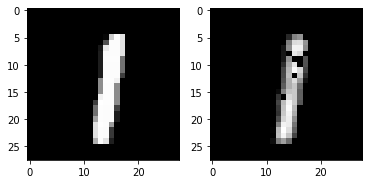

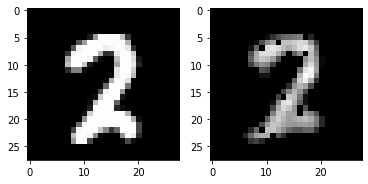

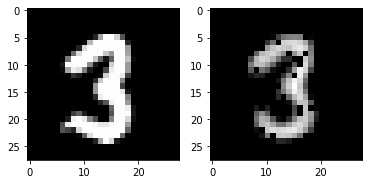

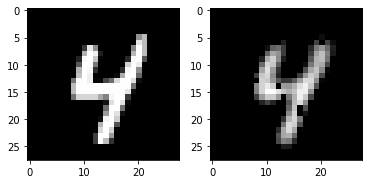

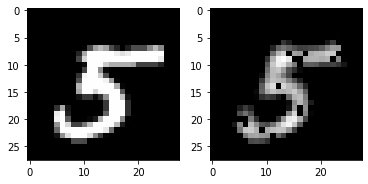

In [16]:
# Q : Define output image from model output on CPU
# Hint) output image shape is torch.Size([16, 1, 28, 28])
# https://pytorch.org/docs/stable/generated/torch.squeeze.html
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [17]:
np.random.seed(42)
from sklearn.manifold import TSNE

In [18]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [19]:
# Q : Define model inputs using test_dataset_array (1~2 lines)
inputs = torch.tensor(test_dataset_array).cuda()

_, encoded = best_model(inputs)
encoded = encoded.cpu().detach().numpy()

In [20]:
tsne = TSNE()
# Q : Embed encoded data using TSNE
X_test_2D = tsne.fit_transform(encoded)

X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


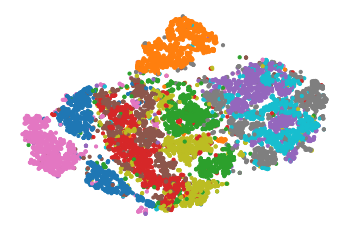

In [21]:
# Q : Fill ??? for scatter plot X, y
# Hint) index 0 for data, index 1 for label
plt.scatter(X_test_2D[:,0], X_test_2D[:,1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

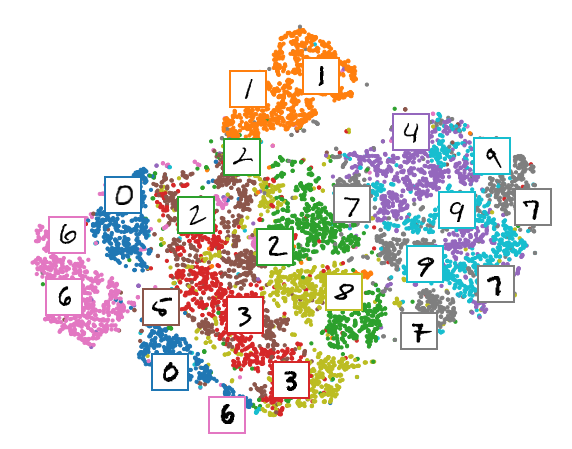

In [22]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [23]:
# Q : Define model, loss function, optimizer (3 lines)
# Hint) Refer to 3.2)
model_D = Autoencoder().cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [24]:
# Q : Add noise to inputs using normal distribution with mean=0, std=0.1
#     Copy above train_model() code and just add 'noise part' (add 3~4 lines)
# Hint) Reshape noise to same shape of inputs -> (inputs.size(0), 1, 28, 28)
#       nn.init.normal : Fills the input Tensor with values drawn from the normal distribution 
#       https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Q : Set model to training mode
                model.train()
            else:
                # Q : Set model to evaluate mode
                model.eval()

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Load input data to GPU
                inputs = inputs.cuda()
                # Add noise
                noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1).cuda()
                noise_inputs = noise + inputs

                # Q : Set parameter gradients zero
                # Hint) Related to 'optimizer'
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Q : input forward to model and fill ??? in loss function
                    outputs, encoded = model(noise_inputs)
                    loss = loss_fn(outputs, inputs) # calculate a loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Q : perform back-propagation and perform gradient descent
                        # Hint ) Backprop is related to 'loss' and Gradient descent is related to 'optimizer'
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # Q : Load best model weights. Fill ???
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [25]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_fn, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.0744
val Loss: 0.0529
Epoch 1/49
----------
train Loss: 0.0429
val Loss: 0.0369
Epoch 2/49
----------
train Loss: 0.0340
val Loss: 0.0318
Epoch 3/49
----------
train Loss: 0.0304
val Loss: 0.0293
Epoch 4/49
----------
train Loss: 0.0284
val Loss: 0.0277
Epoch 5/49
----------
train Loss: 0.0271
val Loss: 0.0265
Epoch 6/49
----------
train Loss: 0.0260
val Loss: 0.0256
Epoch 7/49
----------
train Loss: 0.0253
val Loss: 0.0251
Epoch 8/49
----------
train Loss: 0.0245
val Loss: 0.0242
Epoch 9/49
----------
train Loss: 0.0240
val Loss: 0.0238
Epoch 10/49
----------
train Loss: 0.0236
val Loss: 0.0235
Epoch 11/49
----------
train Loss: 0.0234
val Loss: 0.0233
Epoch 12/49
----------
train Loss: 0.0231
val Loss: 0.0228
Epoch 13/49
----------
train Loss: 0.0228
val Loss: 0.0227
Epoch 14/49
----------
train Loss: 0.0226
val Loss: 0.0226
Epoch 15/49
----------
train Loss: 0.0225
val Loss: 0.0225
Epoch 16/49
----------
train Loss: 0.0224
val Loss: 0.0224
Epoch 1

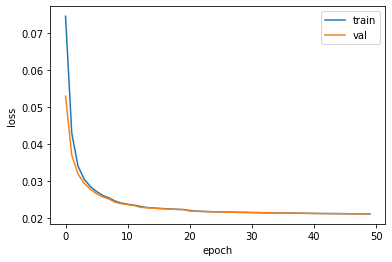

In [26]:
plt.plot(train_loss_history_D, label="train")
plt.plot(val_loss_history_D, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [27]:
# Q : Add noise to inputs using normal distribution with mean=0, std=0.1 
#     Copy above model test code (in 5. Check with Test Image) and just add 'noise part' (add 3~4 lines)
# Hint) Reshape noise to same shape of inputs -> (inputs.size(0), 1, 28, 28)
#       nn.init.normal : Fills the input Tensor with values drawn from the normal distribution 
#       https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_
with torch.no_grad():
    total_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.cuda()
        noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1).cuda()
        noise_inputs = noise + inputs
        outputs, encoded = best_model_D(noise_inputs)
        test_loss = loss_fn(outputs, inputs)
        total_loss += test_loss.item() * inputs.size(0)
    test_loss = total_loss / len(dataloaders["test"].dataset)

print(test_loss)


0.020813325116038322


torch.Size([16, 28, 28])


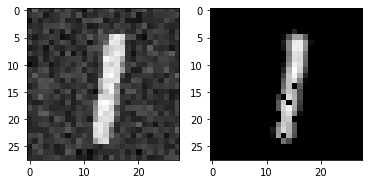

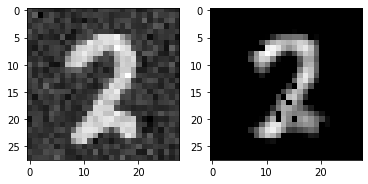

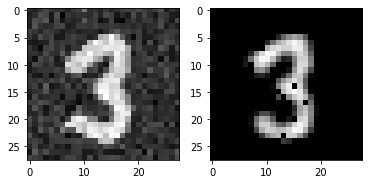

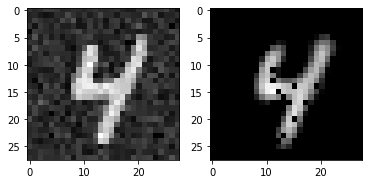

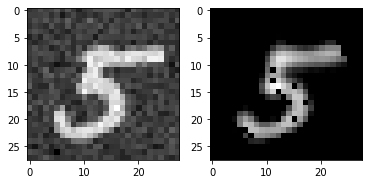

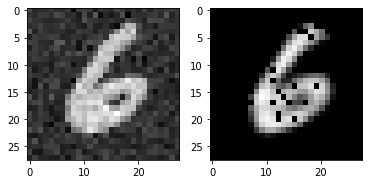

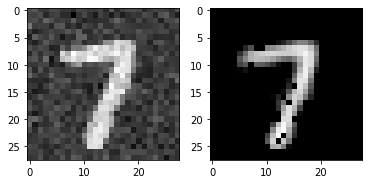

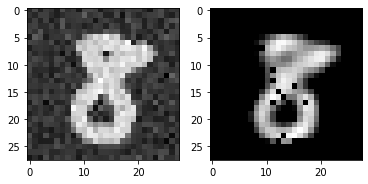

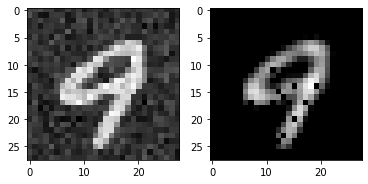

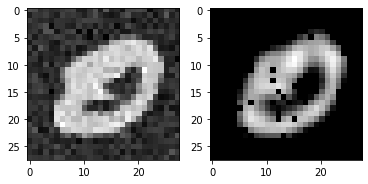

In [28]:
# Q : print out 10 images using code in 5. Check with Test Image
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(10):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()